In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from pandas_profiling import ProfileReport


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Cargar train data
beer = pd.read_csv("./beer_train.csv",
                               index_col = 0)
print(beer.shape)

# Cargar test data
beertest = pd.read_csv("./beer_test.csv",
                               index_col = 0)
print(beertest.shape)

(24066, 16)
(10314, 15)


# Data explanation

#### __Numeric__:
1. __Size(L)__: Amount brewed for recipe listed
2. __OG__ : Specific gravity of wort before fermentation
3. __FG__ : Specific gravity of wort after fermentation
4. __ABV__: Alcohol By Volume
5. __IBU__: International Bittering Units
6. __Color__: Standard Reference Method. Light to dark. Ex. 40 = black
7. __BoilSize__: Fluid at beginning of boil
8. __BoilTime__: Time wort is boiled
9. __BoilGravity__: Specific gravity of wort before the boil
10. __Efficiency__: Beer mash extraction efficiency - extracting sugars from the grain during mash
11. __MashThickness___: Amount of water per pound of grain
12. __PrimaryTemp__: Temperature at the fermenting stage
13. __PitchRate__: Yeast added to the fermentor per gravity unit - M cells/ml/deg P

#### __Categoric__:
1. __SugarScale__: Scale to determine the concentration of dissolved solids in wort
2. __BrewMethod__: Various techniques for brewing
3. __Style__: Type of brew. VARIABLE TO PREDICT

In [3]:
# Percentage of missing values on training data
beer.isnull().sum()/len(beer)*100

Size(L)           0.000000
OG                0.000000
FG                0.000000
ABV               0.000000
IBU               0.000000
Color             0.000000
BoilSize          0.000000
BoilTime          0.000000
BoilGravity       3.889304
Efficiency        0.000000
MashThickness    40.995595
SugarScale        0.000000
BrewMethod        0.000000
PitchRate        54.574919
PrimaryTemp      31.114435
Style             0.000000
dtype: float64

In [4]:
# Percentage of missing values on testing data
beertest.isnull().sum()/len(beertest)*100

Size(L)           0.000000
OG                0.000000
FG                0.000000
ABV               0.000000
IBU               0.000000
Color             0.000000
BoilSize          0.000000
BoilTime          0.000000
BoilGravity       3.218926
Efficiency        0.000000
MashThickness    40.391701
SugarScale        0.000000
BrewMethod        0.000000
PitchRate        54.789606
PrimaryTemp      30.744619
dtype: float64

In [7]:
#Change scale on variables depending on Specific Gravity of Sugar Scale.

beer2 = beer.copy()

beertest2 = beertest.copy()

In [8]:
# group =  beer[beer['SugarScale'] == 'Plato']
# group.OG = group.OG*4
# beer2.OG.update(group.OG)
# group.FG = group.FG*4
# beer2.FG.update(group.FG)

In [9]:
# group.BoilGravity = group.BoilGravity*4
# beer2.BoilGravity.update(group.BoilGravity)

In [10]:
# beertest2 = beertest.copy()
# group3 =  beertest[beertest['SugarScale'] == 'Plato']
# group3.OG = group3.OG*4
# beertest2.OG.update(group3.OG)
# group3.FG = group3.FG*4
# beertest2.FG.update(group3.FG)
# group3.BoilGravity = group3.BoilGravity*4
# beertest2.BoilGravity.update(group3.BoilGravity)


In [206]:
# prof = ProfileReport(beer2)
# prof.to_file(output_file='beer2.html')


In [8]:
beer2['BoilGravity'] = beer2.groupby('Style')['BoilGravity'].transform(
    lambda x: x.fillna(x.mean()))

beertest2['BoilGravity'] = beertest2.fillna(beer2['BoilGravity'].mean())



 #  Mods to datasets

 __MF OHE__

In [9]:
beer2 =  pd.get_dummies(beer2,columns=[ 'SugarScale','BrewMethod'])
beertest2 = pd.get_dummies(beertest,columns= ['SugarScale','BrewMethod'])


In [10]:
beer2.head()

,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp,Style,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
Id,,,,,,,,,,,,,,,,,,,,
0,22.71,1.071,1.021,6.51,81.14,6.43,28.39,90,1.057,78.0,1.2,NaN,20.0,American IPA,0,1,1,0,0,0
1,7.57,1.062,1.016,6.14,138.44,15.28,7.57,60,1.062,35.0,NaN,0.50,20.0,American IPA,0,1,0,0,0,1
2,12.00,1.051,1.012,5.17,27.57,14.54,14.00,60,1.041,65.0,NaN,0.35,20.0,Irish Red Ale,0,1,0,1,0,0
3,15.00,1.051,1.013,5.01,38.53,26.73,19.00,90,1.040,65.0,3.0,NaN,NaN,American Stout,0,1,1,0,0,0
4,21.77,1.061,1.013,6.25,43.20,4.08,23.66,15,1.045,35.0,NaN,0.75,20.0,American IPA,0,1,0,0,0,1


__Drop columns with too many missing data (+40%) & high correlators__


In [11]:
beer2.drop(columns=['MashThickness','PitchRate', ], inplace=True)
beertest2.drop(columns=['MashThickness','PitchRate'], inplace=True)

In [16]:
beer2.drop(columns=['PrimaryTemp' ], inplace=True)
beertest2.drop(columns=['PrimaryTemp'], inplace=True)



In [17]:
beertest2.head()

,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
Id,,,,,,,,,,,,,,,,
0,20.82,15.6465,4.23184,6.21,55.13,8.20,28.01,90,11.800,70.0,1,0,1,0,0,0
1,20.82,1.0570,1.01300,5.71,51.99,6.35,28.39,60,1.042,70.0,0,1,1,0,0,0
2,22.71,1.0580,1.01400,5.67,54.77,24.75,28.39,60,1.046,75.0,0,1,1,0,0,0
3,10.00,1.0520,1.01000,5.51,93.58,5.46,28.50,60,1.018,75.0,0,1,1,0,0,0
4,20.00,12.0478,1.32023,5.70,33.72,3.58,30.00,60,8.100,75.0,1,0,1,0,0,0


 __Save target__

In [19]:
beertarget = beer2['Style']
beertarget.head()

Id
0      American IPA
1      American IPA
2     Irish Red Ale
3    American Stout
4      American IPA
Name: Style, dtype: object

__Fill missing data__

In [20]:
beertarget.head()

Id
0      American IPA
1      American IPA
2     Irish Red Ale
3    American Stout
4      American IPA
Name: Style, dtype: object

 __Outliers?__

In [251]:
# groups_types = beer2.columns.to_series().groupby(beer2.dtypes).unique()
# groups_types.shape, groups_types[0], groups_types[1],  groups_types[2]
# #Numerical data
# groups_types[0:3].tolist()

[array(['BrewMethod_All Grain', 'BrewMethod_BIAB',
        'BrewMethod_Partial Mash', 'BrewMethod_extract'], dtype=object),
 array(['BoilTime'], dtype=object),
 array(['Size(L)', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'Efficiency',
        'PrimaryTemp'], dtype=object)]

In [252]:
# for i in range(0,len(groups_types[2].tolist())):  
    
#     plt.show()

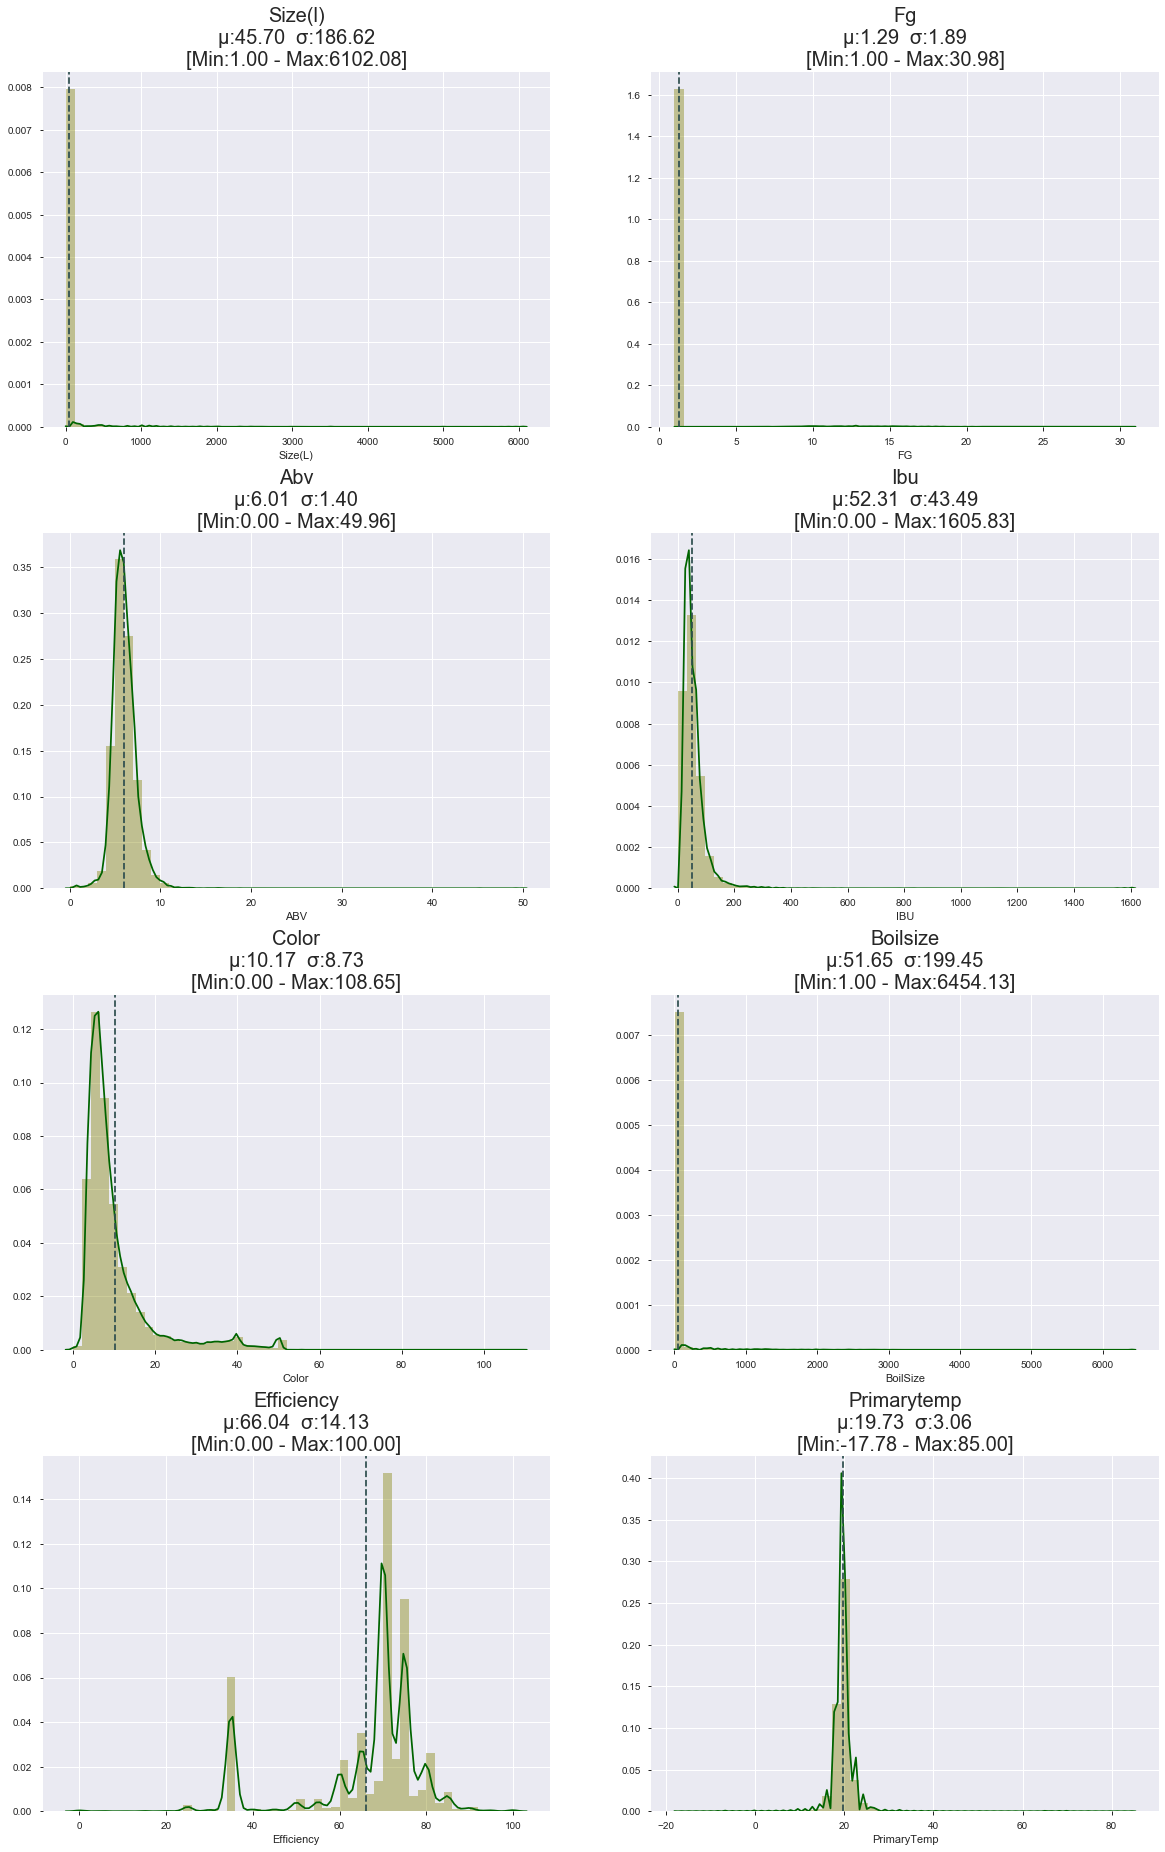

In [253]:
# number_of_plots = len(groups_types[2].tolist())

# n_cols = 2
# n_rows = math.ceil(number_of_plots/n_cols)
# fig, ax = plt.subplots(n_rows ,n_cols,figsize=(20,8*n_rows))

# for i in range(0,len(groups_types[2].tolist())):    
#     myax = ax[i//n_cols,i%n_cols]
    
#     sns.distplot(beer2[groups_types[2].tolist()[i]],\
#                  ax = myax,color = "olive", rug = False,\
#                  rug_kws={"alpha":0.3, "linewidth": 2, "height":0.025 },\
#                  kde_kws={"color":"darkgreen","shade":False},\
#                  hist_kws={})
                
#     mean = beer2[groups_types[2].tolist()[i]].mean()
#     std = beer2[groups_types[2].tolist()[i]].std()
#     min_p = beer2[groups_types[2].tolist()[i]].min()
#     max_p = beer2[groups_types[2].tolist()[i]].max()    
#     text = "\n\u03BC:{:.2f}  \u03C3:{:.2f}\n[Min:{:.2f} - Max:{:.2f}]".format(mean,std,min_p,max_p)
#     myax.set_title(groups_types[2].tolist()[i].capitalize()+text,loc = "center",fontsize = 20)
#     myax.axvline(mean ,0,color = "darkslategrey",linestyle='dashed')
#     plt.subplots_adjust(hspace= 0.3)
   

 __Correlation Matrix__

Text(0.5, 1, 'Covariance Matrix')

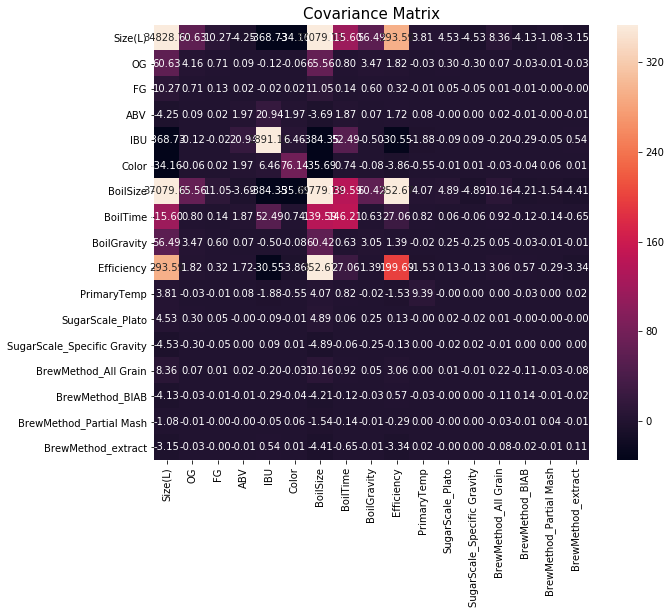

In [50]:
# df_cov = beer2.cov()

# fig, (ax1) = plt.subplots(1,1,figsize = (10,8))
# sns.heatmap(df_cov,ax=ax1,square=True,robust=True,annot = True,fmt =".2f")
# ax1.set_title("Covariance Matrix",fontsize = 15)

Text(0.5, 1, 'Correlation Matrix("Pearson")')

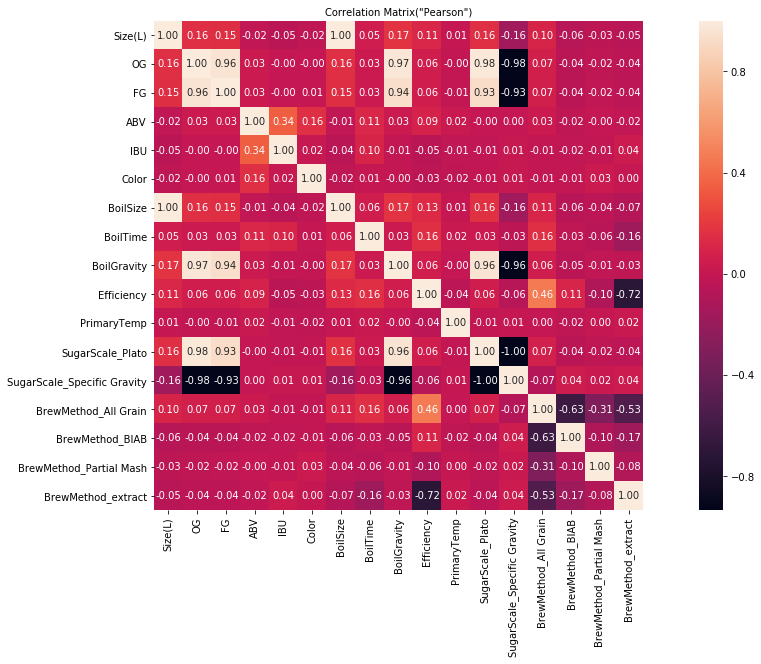

In [53]:
# df_corr = beer2.corr()

# fig, ax1 = plt.subplots(1,1,figsize = (20,9))
# sns.heatmap(df_corr,ax=ax1,square=True,robust=True,annot = True,fmt =".2f")
# ax1.set_title("Correlation Matrix(\"Pearson\")",fontsize = 10)

 __Create target on train data__

 __Normalization__

In [21]:
beer2.drop(columns='Style',inplace=True)

In [31]:
# from sklearn.preprocessing import MinMaxScaler
# scalermm = MinMaxScaler()
# scalermm.fit(beer2)
# scalermm.fit(beertest2)

# Xtrain2 = scalermm.transform(beer2)
# Xtest2 = scalermm.transform(beertest2)

In [235]:
# scaler = StandardScaler()
# scaler.fit(beer2)
# Xtrain2 = scaler.transform(beer2)
# Xtest2 = scaler.transform(beertest2)

In [240]:
# Xtrain2 = pd.DataFrame(Xtrain2, columns=beer2.columns, index=beer2.index)


In [254]:
# Rscaler = RobustScaler()
# Rscaler.fit(beer2)
# Xtrain3 = Rscaler.transform(beer2)
# Xtest3 = Rscaler.transform(beertest2)

In [256]:
# Xtrain4=pd.DataFrame(Xtrain2, columns=beer2.columns)
# Xtrain5=pd.DataFrame(Xtrain3, columns=beer2.columns)



# #Xtrain4.describe()

# Xtrain5.describe()


,Size(L),FG,ABV,IBU,Color,BoilSize,BoilTime,Efficiency,PrimaryTemp,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
count,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000,24066.000000
mean,4.907829,55.834127,0.083832,0.241455,0.490935,2.628032,3.776573,-0.395932,0.141020,-0.333416,0.164547,0.046372,0.122496
std,36.809586,377.867660,0.934802,1.167212,1.481501,22.160968,12.091712,1.413121,2.760877,0.471444,0.370779,0.210295,0.327865
min,-3.909270,-2.800000,-3.920000,-1.162451,-1.235993,-3.000000,-60.000000,-7.000000,-33.654676,-1.000000,0.000000,0.000000,0.000000
25%,-0.372781,-0.400000,-0.466667,-0.396900,-0.344652,-0.777778,0.000000,-0.500000,-0.618640,-1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.627219,0.600000,0.533333,0.603100,0.655348,0.222222,0.000000,0.500000,0.381360,0.000000,0.000000,0.000000,0.000000
max,1199.459566,5994.016000,29.386667,41.938402,17.210526,714.014444,180.000000,3.000000,58.939918,0.000000,1.000000,1.000000,1.000000


In [85]:

# X_test_7=pd.DataFrame(X_test_6, columns=beertest2.columns)
# X_test_5=pd.DataFrame(X_test_4, columns=beertest2.columns)



# X_test_7.describe()
# X_test_5.describe()




,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,PrimaryTemp,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
count,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,1.031400e+04,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000
mean,-0.010513,-0.003251,-0.000227,0.011790,-0.005353,-0.001863,-0.011918,-0.012056,-0.003223,0.000251,-1.756909e-04,-0.000643,0.000643,-0.002292,-0.001606,0.005401,0.001648
std,0.941408,0.976731,1.019650,1.091846,1.074863,0.983492,0.928452,1.016057,0.988710,1.001382,9.166614e-01,0.998012,0.998012,1.000855,0.998593,1.011618,1.001943
min,-0.236858,-0.180225,-0.885536,-4.283171,-1.202810,-1.165686,-0.250457,-5.274513,-0.183979,-4.673488,-1.224118e+01,-0.154349,-6.478812,-1.413949,-0.443797,-0.220516,-0.373626
25%,-0.143460,-0.155215,-0.151881,-0.574642,-0.549446,-0.564026,-0.149828,-0.312334,-0.160517,-0.073645,-2.392628e-01,-0.154349,0.154349,-1.413949,-0.443797,-0.220516,-0.373626
50%,-0.133333,-0.151783,-0.143647,-0.096813,-0.206409,-0.330811,-0.118591,-0.312334,-0.156512,0.280189,4.753167e-14,-0.154349,0.154349,0.707239,-0.443797,-0.220516,-0.373626
75%,-0.113614,-0.147860,-0.135413,0.480862,0.311396,0.113271,-0.108563,-0.312334,-0.150217,0.634023,8.705368e-02,-0.154349,0.154349,0.707239,-0.443797,-0.220516,-0.373626
max,32.452865,10.357337,18.080318,34.741959,49.320224,4.564409,32.101540,12.093115,21.217791,2.403193,1.640288e+01,6.478812,0.154349,0.707239,2.253280,4.534812,2.676472


 __Correlation Matrix__

In [18]:
# X_train_4.to_csv("train4corrmatrix")
# df = pd.read_csv("train4corrmatrix",index_col = 0)


# df = df.corr()

# fig, ax1 = plt.subplots(1,1,figsize = (20,9))
# sns.heatmap(df_corr,ax=ax1,square=True,robust=True,annot = True,fmt =".2f")
# ax1.set_title("Correlation Matrix(\"Pearson\")",fontsize = 10)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

 __Random Forest__

In [129]:
# rfc = RandomForestClassifier(n_estimators=1000, random_state=101, n_jobs=-1)
# rfc.fit(X_train_4, beertarget)
# y_pred_rfc_v7 = rfc.predict(X_test_4)



In [130]:
# y_pred_rfc_v7 = pd.DataFrame(data = y_pred_rfc_v7, 
#                       index = beertest2.index,
#                       columns = ['Style'])

# y_pred_rfc_v7.to_csv("Submission_RandomForest_v6_extradrop.csv")



In [23]:

import xgboost as xgb
n_trees = 1000
lr = 0.05
rs = 101

model = xgb.XGBClassifier(n_estimators=n_trees, learning_rate=lr, random_state=rs,  n_jobs=-1) #for the best model, high number of estimators, low learning rate
model.fit(beer2, beertarget)
acc_xgb_classification = model.predict(beertest2)


In [24]:
y_pred_xgb = pd.DataFrame(data = acc_xgb_classification, 
                      index = beertest2.index,
                      columns = ['Style'])

y_pred_xgb.to_csv("XGBoost_v.2_basic.csv")